In [36]:
import random
import numpy as np
import pandas as pd
from numpy.linalg import norm
from collections import Counter

from gensim.models.doc2vec import Doc2Vec
from mofgraph2vec.featurize.mof2doc import MOF2doc

from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["font.size"] = 16

In [2]:
def cosine(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))

In [3]:
CORPUS_CONFIG = {
  "embed_label": True,
  "label_path": "../data/arc-core-xq.csv",
  "descriptors_to_embed": ["Di", "Df", "Dif", "info.density"],
  "category_to_embed": ["Crystalnet"],
  "tags_to_embed": ["xq.ch4_logkh", "xq.ch4_uptake_580000", "xq.ch4_uptake_6500000"],
  "id_column": "info.name",
  "wl_step": 2,
  "n_components": 2,
  "use_hash": False,
  "writing_style": "paragraph",
  "composition": False,
  "mode": "all",
  "embed_cif": False
}

In [4]:
ARC_MODEL_PATH = "../experiments/workflow/wandb/offline-run-20230920_102517-7gvv4jjv/tmp/embedding_model.pt"
ARC_CORE_MODEL_PATH = ""

In [5]:
ARC_CIF = ["../data/cifs/arc/"]
CORE_CIF = ["../data/cifs/core_md/"]
ARC_CORE_CIF = ["../data/cifs/arc/", "../data/cifs/core_md/"]

In [6]:
def load_vector(test_cif_path, model):
    corpus = {}
    test_ds = MOF2doc(cif_path=test_cif_path, **CORPUS_CONFIG).get_documents()
    for dp in test_ds:
        corpus.update(
            {dp.tags[0]: model.dv[dp.tags[0]]}
        )
    return corpus

In [7]:
arc_model = Doc2Vec.load(ARC_MODEL_PATH)

In [8]:
df = pd.read_csv("../data/arc-merge-xq.csv")

# ARC for ARC

In [9]:
arc_model = Doc2Vec.load(ARC_MODEL_PATH)

In [10]:
arc_vec = load_vector(ARC_CIF, arc_model)

/Users/xiaoqi/Documents/projects/proj_unsupervisedML/codes/mofgraph2vec/src/mofgraph2vec/featurize/mof2doc.py:44: DtypeWarning: Columns (23,26,102,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df_label = pd.read_csv(label_path).set_index(id_column)
100%|██████████| 22035/22035 [00:31<00:00, 690.20it/s]


In [11]:
df["binned_ch4_logkh"] = pd.qcut(df["xq.ch4_logkh"], q=[0,0.75,1], labels=[0,1])
top_list = df[df["binned_ch4_logkh"] == 1]["info.name"].values
rest_list = df[df["binned_ch4_logkh"] == 0]["info.name"].values

## p-value

In [22]:
n_reference = 1000
reference = random.choices(df["info.name"].values, k=n_reference)

In [23]:
similar_matrix = []
for i in reference:
    row = []
    for j in reference:
        row.append(
            cosine(arc_vec[i], arc_vec[j])
        )
    similar_matrix.append(row)

In [24]:
thresholds = np.arange(-1, 1.05, 0.05)

In [25]:
p_value = []
for th in thresholds:
    p = sum(sum(np.array(similar_matrix) >= th)) / (n_reference**2)
    p_value.append(p)

In [26]:
ref_vec = arc_model.dv["xq.ch4_logkh_low"]

sim_to_ref = []
for r in reference:
    sim_to_ref.append(cosine(arc_vec[r], ref_vec))

p_to_low = []
for th in thresholds:
    p = sum(np.array(sim_to_ref) >= th) / len(sim_to_ref)
    p_to_low.append(p)

In [27]:
ref_vec = arc_model.dv["xq.ch4_logkh_medium"]

sim_to_ref = []
for r in reference:
    sim_to_ref.append(cosine(arc_vec[r], ref_vec))

p_to_med = []
for th in thresholds:
    p = sum(np.array(sim_to_ref) >= th) / len(sim_to_ref)
    p_to_med.append(p)

In [28]:
ref_vec = arc_model.dv["xq.ch4_logkh_high"]

sim_to_ref = []
for r in reference:
    sim_to_ref.append(cosine(arc_vec[r], ref_vec))

p_to_high = []
for th in thresholds:
    p = sum(np.array(sim_to_ref) >= th) / len(sim_to_ref)
    p_to_high.append(p)

If such threshold values are generally applicable in the context of similarity searching, i.e., if a similarity value exceeding a threshold value is a rare event and thus indicates significant similarity, they must be largely independent of the selected reference compound.

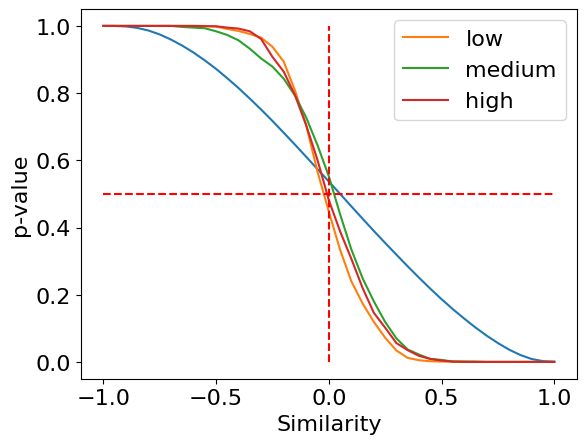

In [29]:
plt.plot(thresholds, p_value)
plt.plot(thresholds, p_to_low, label="low")
plt.plot(thresholds, p_to_med, label="medium")
plt.plot(thresholds, p_to_high, label="high")

plt.xlabel("Similarity")
plt.ylabel("p-value")

plt.plot([-1, 1], [0.5, 0.5], 'r--')
plt.plot([0,0], [0,1], 'r--')

plt.legend()

#plt.xlim([0.5,1])

## Recommendation on threshold value

In [30]:
ref_vec = arc_model.dv["xq.ch4_logkh_high"]
df["xq.ch4_logkh_high_similarity"] = [cosine(arc_vec[r], ref_vec) for r in df["info.name"].values]

(array([  1.,   0.,   0.,   1.,   0.,   0.,   4.,   3.,   3.,   4.,   2.,
          4.,  10.,  15.,  15.,  18.,  16.,  31.,  42.,  41.,  54.,  71.,
         90., 108., 123., 154., 167., 161., 197., 254., 242., 286., 288.,
        328., 352., 403., 452., 455., 487., 509., 562., 547., 542., 568.,
        638., 562., 622., 659., 658., 638., 634., 613., 623., 565., 588.,
        534., 491., 497., 483., 442., 450., 397., 385., 357., 359., 309.,
        297., 268., 271., 229., 229., 210., 170., 171., 138., 129., 120.,
        107., 102.,  68.,  60.,  51.,  57.,  45.,  41.,  29.,  29.,  19.,
         16.,  12.,  19.,   7.,  11.,   4.,   2.,   1.,   3.,   2.,   1.,
          3.]),
 array([-0.64884269, -0.63575542, -0.62266815, -0.60958093, -0.59649366,
        -0.58340639, -0.57031912, -0.55723184, -0.54414457, -0.53105736,
        -0.51797009, -0.50488281, -0.49179554, -0.4787083 , -0.46562102,
        -0.45253375, -0.43944651, -0.42635924, -0.41327196, -0.40018472,
        -0.38709745, -0.37

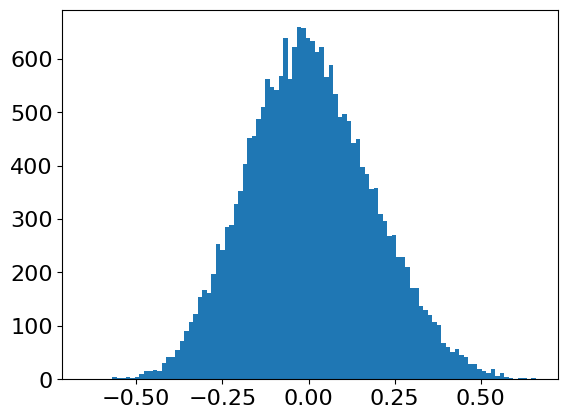

In [32]:
plt.hist(df["xq.ch4_logkh_high_similarity"].values, bins=100)

In [94]:
ch4_logkh_high_recom = df[df["xq.ch4_logkh_high_similarity"] > 0.3]

In [95]:
Counter(df["binned_ch4_logkh"].values)

Counter({0: 16526, 1: 5509})

In [96]:
recom_count = Counter(ch4_logkh_high_recom["binned_ch4_logkh"].values)
print(recom_count[1]/(recom_count[0]+recom_count[1]))

0.3298429319371728


(array([ 5.84254513,  5.84254513,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 11.68509026,  0.        ,  0.        ,
         0.        ,  0.        ,  5.84254513,  0.        ,  0.        ,
         0.        ,  5.84254513,  0.        ,  0.        ,  0.        ,
        11.68509026,  0.        ,  0.        ,  0.        ,  5.84254513,
         0.        ,  0.        ,  0.        ,  0.        ,  5.84254513]),
 array([-5.13587177, -5.11875594, -5.10164011, -5.08452428, -5.06740845,
        -5.05029262, -5.03317679, -5.01606097, -4.99894514, -4.98182931,
        -4.96471348, -4.94759765, -4.93048182, -4.913366  , -4.89625017,
        -4.87913434, -4.86201851, -4.84490268, -4.82778685, -4.81067103,
        -4.7935552 , -4.77643937, -4.75932354, -4.74220771, -4.72509188,
        -4.70797605, -4.69086023, -4.6737444 , -4.65662857, -4.63951274,
        -4.62239691]),
 <BarContainer object of 30 artists>)

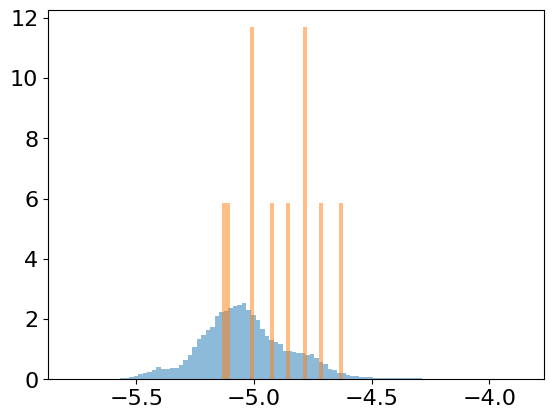

In [66]:
plt.hist(df["xq.ch4_logkh"].values, bins=100, density=True, alpha=.5)
plt.hist(ch4_logkh_high_recom["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)

In [68]:
df.keys()

Index(['Name', 'UC_volume', 'Density', 'ASA', 'vASA', 'gASA', 'NASA', 'gNASA',
       'vNASA', 'AVA', 'AVAf', 'AVAg', 'NAVA', 'NAVAf', 'NAVAg', 'POAVA',
       'POAVAf', 'POAVAg', 'NPOAVA', 'NPOAVAf', 'NPOAVAg', 'Di', 'Df', 'Dif',
       'ARC-MOF', 'DB_num', 'order_geo', 'bool_geo', 'cifname_x', 'filename',
       'Crystalnet', 'likely topology', 'cifname_y',
       'info.undecorated_graph_hash', 'info.undecorated_no_leaf_hash',
       'info.undecorated_scaffold_hash', 'info.decorated_graph_hash',
       'info.decorated_no_leaf_hash', 'info.decorated_scaffold_hash',
       'info.name', 'outputs.postcombustion_vsa_uptake-mmol/g',
       'outputs.postcombustion_vsa_working_capacity-mmol/g',
       'outputs.postcombustion_vsa_v/v-uptake-',
       'outputs.postcombustion_vsa_v/v_working_capacity-',
       'outputs.postcombustion_vsa_wt%_uptake-',
       'outputs.postcombustion_vsa_wt%_working_capacity-',
       'outputs.postcombustion_vsa_selectivity-',
       'outputs.postcombustion_vsa_p

In [73]:
ch4_logkh_high_recom

,Name,UC_volume,Density,ASA,vASA,gASA,NASA,gNASA,vNASA,AVA,...,xq.ch4_uptake_580000_dev,methane_enthalpy_580000,methane_enthalpy_580000_dev,xq.ch4_uptake_6500000,xq.ch4_uptake_6500000_dev,methane_enthalpy_6500000,methane_enthalpy_6500000_dev,xq.ch4_logkh,binned_ch4_logkh,xq.ch4_logkh_high_similarity
4355,DB0-m29_o89_o53_f0_pts.sym.58.cif,2922.69,0.790163,562.532,1924.71,2435.83,0.00000,0.0000,0.0000,274.440,...,0.154976,-18.94460,0.794429,11.490594,0.079921,-19.68091,1.252101,-4.622397,1,0.619179
5132,DB0-m29_o99_o92_f0_pts.sym.33.cif,4036.56,0.521051,738.250,1828.91,3510.04,0.00000,0.0000,0.0000,1521.540,...,0.129627,-12.55049,0.175236,18.494534,0.066068,-14.25574,0.507405,-5.114843,0,0.659883
5151,DB0-m29_o89_o92_f0_pts.sym.25.cif,3243.93,0.721615,555.085,1711.15,2371.28,0.00000,0.0000,0.0000,683.172,...,0.135130,-15.45297,0.789901,12.233459,0.126754,-16.85058,1.069112,-5.005848,0,0.609368
6337,DB0-m29_o89_o510_f0_pts.sym.39.cif,2424.15,0.744916,459.952,1897.37,2547.09,0.00000,0.0000,0.0000,360.811,...,0.228977,-16.06772,0.620256,11.897476,0.183892,-18.49108,0.899285,-4.921569,1,0.656348
9465,DB0-m29_o89_o45_f0_pts.sym.94.cif,2232.09,0.803016,428.471,1919.60,2390.48,0.00000,0.0000,0.0000,208.611,...,0.098292,-17.79509,0.576718,9.912298,0.086727,-18.03442,1.824602,-4.722859,1,0.610757
10443,DB0-m29_o89_o44_f0_pts.sym.102.cif,2298.52,0.757403,479.697,2086.98,2755.45,0.00000,0.0000,0.0000,225.393,...,0.040350,-17.40280,0.290408,11.015976,0.044811,-18.12616,1.308671,-4.787820,1,0.625601
11927,DB0-m29_o96_o92_f0_pts.sym.8.cif,6388.80,0.419029,1267.950,1984.65,4736.29,0.00000,0.0000,0.0000,2973.220,...,0.142485,-11.24771,0.390746,22.481742,0.323791,-12.57070,0.781288,-5.135872,0,0.601996
15708,DB0-m29_o91_o470_f0_pts.sym.83.cif,2791.14,0.679690,609.295,2182.96,3211.70,0.00000,0.0000,0.0000,606.626,...,0.090109,-14.71246,0.574231,14.362369,0.075692,-17.93609,1.043738,-5.000429,0,0.643906
18888,DB0-m29_o93_o470_f0_pts.sym.60.cif,2301.95,0.889144,319.772,1389.14,1562.33,6.79966,29.5387,33.2215,149.488,...,0.111715,-19.66624,0.607516,9.449310,0.099188,-20.50244,2.182564,-4.783715,1,0.625108
20231,DB0-m29_o92_o45_f0_pts.sym.33.cif,3588.52,0.629657,726.480,2024.46,3215.17,0.00000,0.0000,0.0000,949.666,...,0.049773,-14.76232,0.815881,14.293847,0.178291,-15.43417,0.394361,-4.851579,1,0.648722


In [69]:
df_missed = df[df["binned_ch4_logkh"] == 1]
df_missed = df_missed[~df_missed["info.name"].isin(ch4_logkh_high_recom["info.name"].values)]

In [74]:
df_missed

,Name,UC_volume,Density,ASA,vASA,gASA,NASA,gNASA,vNASA,AVA,...,xq.ch4_uptake_580000_dev,methane_enthalpy_580000,methane_enthalpy_580000_dev,xq.ch4_uptake_6500000,xq.ch4_uptake_6500000_dev,methane_enthalpy_6500000,methane_enthalpy_6500000_dev,xq.ch4_logkh,binned_ch4_logkh,xq.ch4_logkh_high_similarity
6,DB0-m2_o10_o16_f0_pcu.sym.40.cif,831.863,1.118700,121.441,1459.86,1304.96,0.0,0.0,0.0,48.3313,...,0.032143,-21.82218,0.956092,6.601866,0.062828,-21.15277,2.699965,-4.398836,1,0.001032
9,DB0-m29_o93_o111_f0_pts.sym.62.cif,2685.490,0.688421,586.841,2185.23,3174.26,0.0,0.0,0.0,512.8210,...,0.154372,-15.58834,0.682865,13.561568,0.077002,-17.08438,0.708897,-4.903935,1,-0.089998
15,DB0-m29_o97_o44_f0_pts.sym.105.cif,2742.820,0.596538,612.738,2233.97,3744.90,0.0,0.0,0.0,834.8050,...,0.108942,-14.66483,0.924040,16.641391,0.220993,-15.03515,0.717798,-4.770733,1,-0.151081
17,DB0-m29_o95_o47_f0_pts.sym.59.cif,2632.940,0.758434,601.510,2284.56,3012.20,0.0,0.0,0.0,327.9590,...,0.171429,-19.34474,0.792261,13.396293,0.127593,-20.17734,1.623756,-4.503771,1,-0.078400
18,DB0-m29_o89_o51_f0_pts.sym.61.cif,2223.740,0.686489,505.237,2272.02,3309.62,0.0,0.0,0.0,365.0040,...,0.187241,-15.92329,0.709292,13.628718,0.216500,-17.09899,0.713764,-4.794433,1,0.383447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22012,DB0-m29_o89_o45_f0_pts.sym.16.cif,2235.350,0.737987,440.213,1969.32,2668.51,0.0,0.0,0.0,347.9550,...,0.107960,-16.54673,0.469098,12.106184,0.133864,-18.84488,1.393550,-4.769120,1,0.168816
22017,DB0-m29_o97_o44_f0_pts.sym.69.cif,2740.850,0.652137,640.627,2337.33,3584.12,0.0,0.0,0.0,670.5760,...,0.145096,-14.84124,0.590718,15.086617,0.107300,-15.92339,0.788572,-4.760260,1,0.127572
22021,DB0-m29_o97_o470_f0_pts.sym.35.cif,2591.140,0.642397,547.200,2111.81,3287.39,0.0,0.0,0.0,691.9390,...,0.159975,-15.13125,0.464840,16.805478,0.256588,-17.62960,1.002253,-4.919792,1,-0.273863
22024,DB0-m29_o89_o46_f0_pts.sym.76.cif,1717.520,0.854898,278.995,1624.41,1900.12,0.0,0.0,0.0,188.2740,...,0.147624,-17.26578,0.406058,9.378467,0.210642,-18.12066,0.947411,-4.890881,1,-0.021503


In [98]:
df.nlargest(10, "xq.ch4_logkh")

,Name,UC_volume,Density,ASA,vASA,gASA,NASA,gNASA,vNASA,AVA,...,xq.ch4_uptake_580000_dev,methane_enthalpy_580000,methane_enthalpy_580000_dev,xq.ch4_uptake_6500000,xq.ch4_uptake_6500000_dev,methane_enthalpy_6500000,methane_enthalpy_6500000_dev,xq.ch4_logkh,binned_ch4_logkh,xq.ch4_logkh_high_similarity
20918,DB0-m2_o10_o17_f0_pcu.sym.45.cif,924.922,1.40129,0.0000,0.000,0.000,31.9766,345.722,246.716,0.00000,...,0.203680,-27.65224,2.367155,3.885160,0.094768,-22.96857,3.431266,-3.862906,1,0.232567
10550,DB0-m2_o10_o17_f0_pcu.sym.58.cif,922.089,1.40560,0.0000,0.000,0.000,35.7600,387.816,275.908,0.00000,...,0.073476,-28.28348,2.677299,4.007159,0.188228,-25.86582,5.786657,-3.885860,1,0.427356
5835,DB0-m2_o10_o17_f0_pcu.sym.32.cif,926.218,1.39933,41.9038,452.418,323.310,0.0000,0.000,0.000,3.92717,...,0.104656,-28.00728,1.898200,3.927417,0.131030,-21.42054,2.372609,-3.891087,1,0.258506
413,DB0-m2_o10_o17_f0_pcu.sym.4.cif,924.775,1.27782,0.0000,0.000,0.000,40.4498,437.402,342.304,0.00000,...,0.066998,-28.82956,2.669971,4.441898,0.098460,-21.30313,6.511560,-3.909569,1,0.098020
21090,DB0-m2_o10_o17_f0_pcu.sym.42.cif,926.867,1.33939,0.0000,0.000,0.000,40.0875,432.506,322.912,0.00000,...,0.045151,-27.60906,2.497503,4.219179,0.052872,-21.95632,6.679141,-3.922785,1,0.028142
977,DB0-m2_o10_o18_f0_pcu.sym.31.cif,973.905,1.38735,56.7871,583.086,420.287,0.0000,0.000,0.000,19.32230,...,0.058222,-25.01216,1.632269,3.161908,0.064185,-24.22143,5.582722,-3.984133,1,0.403884
9261,DB0-m2_o10_o18_f0_pcu.sym.26.cif,974.619,1.13404,141.0390,1447.120,1276.070,0.0000,0.000,0.000,52.22010,...,0.111069,-24.96699,0.753287,6.886492,0.082821,-23.76011,2.548391,-4.034306,1,0.149460
3498,DB0-m2_o10_o18_f0_pcu.sym.9.cif,972.781,1.30020,65.5274,673.609,518.081,0.0000,0.000,0.000,22.78250,...,0.082982,-24.20678,3.244315,3.411346,0.208284,-22.45493,4.742022,-4.037719,1,0.380750
12629,DB0-m2_o10_o14_f0_pcu.sym.35.cif,674.691,1.33264,48.0363,711.976,534.260,0.0000,0.000,0.000,15.40990,...,0.150375,-24.49143,1.258703,4.443598,0.160214,-23.31644,3.135196,-4.059770,1,0.270448
9087,DB0-m2_o10_o18_f0_pcu.sym.21.cif,980.854,1.13366,129.2850,1318.080,1162.680,0.0000,0.000,0.000,41.78440,...,0.037528,-25.17105,1.610573,6.654885,0.100616,-23.58542,5.349791,-4.063793,1,0.097814


In [180]:
recom_on_mof = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.45_repeat", negative="xq.ch4_logkh_high", topn=40)]

In [178]:
recom_on_mof_ori = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.45_repeat", topn=40)]

In [163]:
recom_on_mof2 = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.58_repeat", topn=40)]

In [164]:
recom_on_mof3 = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.32_repeat", topn=40)]

In [165]:
recom_on_mof4 = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.4_repeat", topn=40)]

In [166]:
recom_on_mof5 = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.42_repeat", topn=40)]

In [167]:
recom_on_mof6 = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o18_f0_pcu.sym.31_repeat", topn=40)]

In [168]:
values = np.array([df[df["info.name"].isin(recom_on_mof)]["xq.ch4_logkh"].values, 
                   df[df["info.name"].isin(recom_on_mof2)]["xq.ch4_logkh"].values,
                   df[df["info.name"].isin(recom_on_mof3)]["xq.ch4_logkh"].values,
                   df[df["info.name"].isin(recom_on_mof4)]["xq.ch4_logkh"].values,
                   df[df["info.name"].isin(recom_on_mof5)]["xq.ch4_logkh"].values,
                   df[df["info.name"].isin(recom_on_mof6)]["xq.ch4_logkh"].values,
                   ]).reshape(-1, 6)

In [169]:
values.shape

(40, 6)

(array([1.79130367, 2.3884049 , 3.58260735, 4.17970857, 0.59710122,
        0.59710122, 0.59710122, 1.19420245, 0.        , 1.19420245,
        2.3884049 , 1.79130367, 1.79130367, 0.59710122, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.19420245]),
 array([-5.14192802, -5.10005908, -5.05819013, -5.01632118, -4.97445223,
        -4.93258328, -4.89071434, -4.84884539, -4.80697644, -4.76510749,
        -4.72323855, -4.6813696 , -4.63950065, -4.5976317 , -4.55576275,
        -4.51389381, -4.47202486, -4.43015591, -4.38828696, -4.34641802,
        -4.30454907, -4.26268012, -4.22081117, -4.17894222, -4.13707328,
        -4.09520433, -4.05333538, -4.01146643, -3.96959749, -3.92772854,
        -3.88585959]),
 <BarContainer object of 30 artists>)

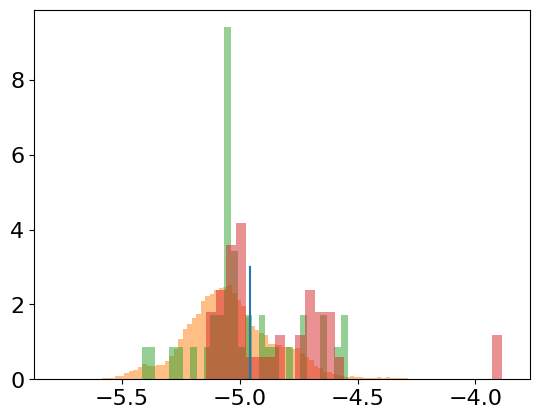

In [181]:
q = df["xq.ch4_logkh"].quantile(q=0.7)
plt.plot([q,q], [0,3])
plt.hist(df["xq.ch4_logkh"].values, bins=100, density=True, alpha=.5)
#plt.hist(values, bins=50, density=True, alpha=.5, histtype='bar', stacked=True)
plt.hist(df[df["info.name"].isin(recom_on_mof)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)
plt.hist(df[df["info.name"].isin(recom_on_mof_ori)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)
#plt.hist(df[df["info.name"].isin(recom_on_mof2)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)
#plt.hist(df[df["info.name"].isin(recom_on_mof3)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)
#plt.hist(df[df["info.name"].isin(recom_on_mof4)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)
#plt.hist(df[df["info.name"].isin(recom_on_mof5)]["xq.ch4_logkh"].values, bins=30, density=True, alpha=.5)

## Comparison between vector operation

In [182]:
rm_ori = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.45_repeat", topn=40)]
rm_neg_low = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.45_repeat", negative="xq.ch4_logkh_low", topn=40)]
rm_neg_high = [x[0] for x in arc_model.dv.most_similar("DB0-m2_o10_o17_f0_pcu.sym.45_repeat", negative="xq.ch4_logkh_high", topn=40)]
rm_pos_low = [x[0] for x in arc_model.dv.most_similar(["DB0-m2_o10_o17_f0_pcu.sym.45_repeat", "xq.ch4_logkh_low"], topn=40)]
rm_pos_high = [x[0] for x in arc_model.dv.most_similar(["DB0-m2_o10_o17_f0_pcu.sym.45_repeat", "xq.ch4_logkh_high"], topn=40)]


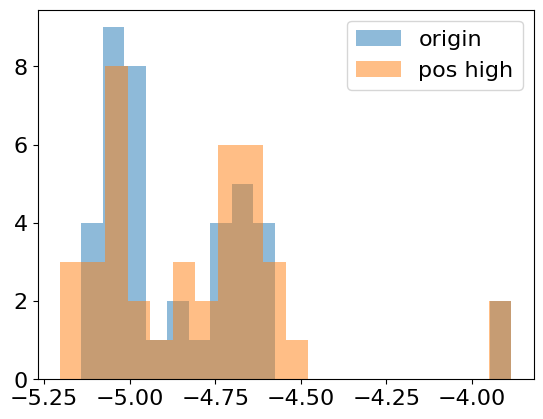

In [190]:
plt.hist(df[df["info.name"].isin(rm_ori)]["xq.ch4_logkh"].values, label="origin", alpha=.5, bins=20)
#plt.hist(df[df["info.name"].isin(rm_neg_low)]["xq.ch4_logkh"].values, label="neg low", alpha=.5, bins=20)
#plt.hist(df[df["info.name"].isin(rm_neg_high)]["xq.ch4_logkh"].values, label="neg high", alpha=.5, bins=20)
#plt.hist(df[df["info.name"].isin(rm_pos_low)]["xq.ch4_logkh"].values, label="pos low", alpha=.5, bins=20)
plt.hist(df[df["info.name"].isin(rm_pos_high)]["xq.ch4_logkh"].values, label="pos high", alpha=.5, bins=20)
plt.legend()